# Refitting WT binding energies from glucose data 

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
import numpy as np
import pandas as pd
import pystan
sys.path.insert(0, '../../')
import mwc.bayes
import mwc.stats
import mwc.viz
import altair as alt
import bokeh.io
alt.data_transformers.enable('json')
bokeh.io.output_notebook()
# %load_ext stanmagic

Loading BokehJS ...

I would like to be able to have reliable confidence intervals based on my glucose data. While using the energies determined by Hernan is valid, I would reather determine the binding energy myself since I have reliable repressor counts.  

In [2]:
# Load the compiled data set. 
fc_data = pd.read_csv('../../data/compiled_fold_change.csv')

# Load the fluctutations
fluct_data = pd.read_csv('../../data/compiled_fluctuations.csv') 

# Isolate glucose data. 
gluc_fc = fc_data[(fc_data['carbon']=='glucose') & (fc_data['strain']=='dilution')].copy()
gluc_fluct = fluct_data[(fluct_data['carbon']=='glucose')].copy()

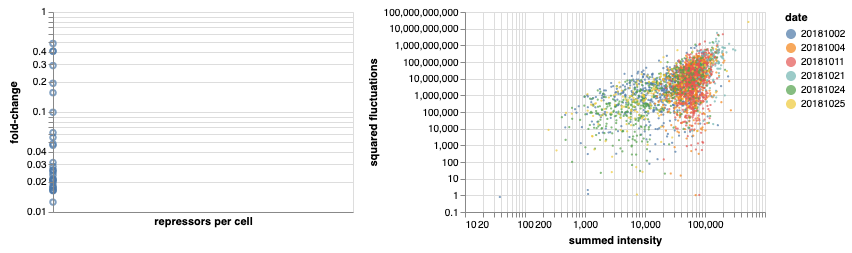

In [3]:
# Plot all glucose data. 
fc_points = alt.Chart(data=gluc_fc[gluc_fc['fold_change'] >= 0],
                     width=300, height=200).mark_point(
    ).encode(
        x=alt.X('mean_rep:Q', scale={'type':'log'}, axis={'title':'repressors per cell'}), 
        y=alt.Y('mean_fc:Q', scale={'type':'log'}, axis={'title':'fold-change'})
    ).transform_aggregate(
        mean_rep='mean(repressors)',
        mean_fc='mean(fold_change)',
        groupby=['atc_ngml','run_number', 'date'])

# Plot the fluctuation data. 
fluct_points = alt.Chart(data=gluc_fluct[(gluc_fluct['summed'] > 0) &
                                        (gluc_fluct['sq_fluct'] > 0)],
                         width=300, height=200
    ).mark_point(filled=True, size=5
    ).encode(
    x=alt.X('summed:Q', scale={'type':'log'}, axis={'title':'summed intensity'}),
    y=alt.Y('sq_fluct:Q', scale={'type':'log'}, axis={'title':'squared fluctuations'}),
    color='date:N') 

fc_points | fluct_points

In [23]:
# Load the stan model
model = pystan.StanModel('../stan/simultaneous_epRA_cal_factor.stan', include_paths='../stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_85f972cfca59d77ba811fd1c2524a7c5 NOW.
/home/ec2-user/miniconda/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp045fzctm/stanfit4anon_model_85f972cfca59d77ba811fd1c2524a7c5_7745754075963077188.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [28]:
# Add identifiers. 
gluc_fc = gluc_fc[gluc_fc['mean_mCherry'] >= 0].copy()
gluc_fc['conc_idx'] = gluc_fc.groupby(['atc_ngml']).ngroup() + 1
gluc_fc['run_idx'] = gluc_fc.groupby(['date', 'run_number']).ngroup() + 1
gluc_fc['conc_run_idx'] = gluc_fc.groupby(['date', 'run_number', 'atc_ngml']).ngroup() + 1
gluc_fluct['run_idx'] = gluc_fluct.groupby(['date', 'run_no']).ngroup() + 1
gluc_fc['tot_mCherry'] = gluc_fc['mean_mCherry'] * gluc_fc['area_pix']

# Group by the individual runs and compute the means. 
grouped = gluc_fc.groupby(['conc_run_idx']).mean().reset_index()

# Assemble the data dictionary. 
data_dict = {'J_conc': grouped['conc_idx'].max(),
            'J_runs': grouped['run_idx'].max(),
            'N_fluct':len(gluc_fluct),
            'N_fc':len(grouped),
            'fluct_index': gluc_fluct['run_idx'],
            'fc_index_run':grouped['run_idx'],
            'fc_index_conc':grouped['conc_idx'],
            'fc_index_replicates': grouped['conc_run_idx'],
            'I_1':gluc_fluct['I_1'],
            'I_2': gluc_fluct['I_2'],
            'mean_mCherry': grouped['tot_mCherry'],
            'fc': grouped['fold_change'],
            'Nns':4.6E6,
            'ep_AI':4.5}
# Sample!
samples = model.sampling(data=data_dict, iter3000, control=dict(adapt_delta=0.95,
                                                                max_treedepth=11))

In [29]:
import bebi103
p = bebi103.viz.corner(samples.to_dataframe(),['alpha_mu', 'alpha_sigma', 'ep_RA', 'sigma'], datashade=False)
bokeh.io.show(p)